# Event Detection (& Association)
The first stage of the monitoring process is to detect anomalous events - short, transient signals of a few seconds to 1-2 minutes. The classic approach (since late 1970s?) has been to use a Short-Term Average (STA) to Long-Term Average (LTA) ratio-based Detector.

## Steps:
- Run an <b>STA/LTA Detector</b> on each channel of continuous waveform data (to each ObsPy Trace object wthin a Stream object).This yields a set of Trigger (or Detection) ON and OFF times.
- Run an <b>Associator</b> on the full set of Triggers. If multiple channels have Trigger ON status at the same time, record as an Event in a Catalog.

In ObsPy, both steps can be done using `coincidence_trigger` from the `obspy.signal.trigger` package.

## Examples:
1. Run an STA/LTA Detector on a single channel of data, on just 1 hour of data.
2. Run an STA/LTA Detector and Associator on multiple channels of data (a Stream object), on just 1 hour of data.
3. Run an STA/LTA Detection and Associator on multiple channels of data (a Stream object), for multiple days of data.

The continuous waveform data will come from a "SeisComP Data Structure" (https://docs.obspy.org/packages/autogen/obspy.clients.filesystem.sds.html) or "SDS" archive. We will explore this first. We can create a client connection to as SDS archive using the Client class from the `obspy.clients.filesystem.sds` package.

In [13]:
# Import general packages
import os
import sys
from pathlib import Path
import obspy

# Import local packages
sys.path.append('..')
import vsmTools

# Define where SDS archive and EVENTS data are stored
SDS_DIR = os.path.join('..', 'data','continuous','SDS')
EVENTS_DIR = os.path.join('..', 'data','events')
CATALOG_DIR = os.path.join('..', 'data','catalogs')

# Create a connection to an SDS archive
from obspy.clients.filesystem.sds import Client
sdsclient = Client(SDS_DIR)

# Show a tree listing of SDS_DIR
print('Tree listing of SDS_DIR directory')
for line in vsmTools.tree(Path(SDS_DIR)):
    print(line)

# Set start time as "YYYYJJJT" where JJJ = (Julian calendar) day of year
stime = obspy.UTCDateTime("2003196T")
print(stime)

Tree listing of SDS_DIR directory
├── 2001
│   └── MV
│       ├── MBRY
│       │   ├── BHE.D
│       │   │   ├── MV.MBRY..BHE.D.2001.208
│       │   │   ├── MV.MBRY..BHE.D.2001.209
│       │   │   ├── MV.MBRY..BHE.D.2001.211
│       │   │   ├── MV.MBRY..BHE.D.2001.212
│       │   │   ├── MV.MBRY..BHE.D.2001.207
│       │   │   ├── MV.MBRY..BHE.D.2001.214
│       │   │   ├── MV.MBRY..BHE.D.2001.210
│       │   │   └── MV.MBRY..BHE.D.2001.213
│       │   ├── BHN.D
│       │   │   ├── MV.MBRY..BHN.D.2001.212
│       │   │   ├── MV.MBRY..BHN.D.2001.211
│       │   │   ├── MV.MBRY..BHN.D.2001.207
│       │   │   ├── MV.MBRY..BHN.D.2001.214
│       │   │   ├── MV.MBRY..BHN.D.2001.208
│       │   │   ├── MV.MBRY..BHN.D.2001.213
│       │   │   ├── MV.MBRY..BHN.D.2001.209
│       │   │   └── MV.MBRY..BHN.D.2001.210
│       │   └── BHZ.D
│       │       ├── MV.MBRY..BHZ.D.2001.211
│       │       ├── MV.MBRY..BHZ.D.2001.210
│       │       ├── MV.MBRY..BHZ.D.2001.208
│       │       ├── MV.MBRY

## Example 1: Detect anomalous signals in 1 hour of data

First we load one hour of data from the SDS archive (multiple channels):

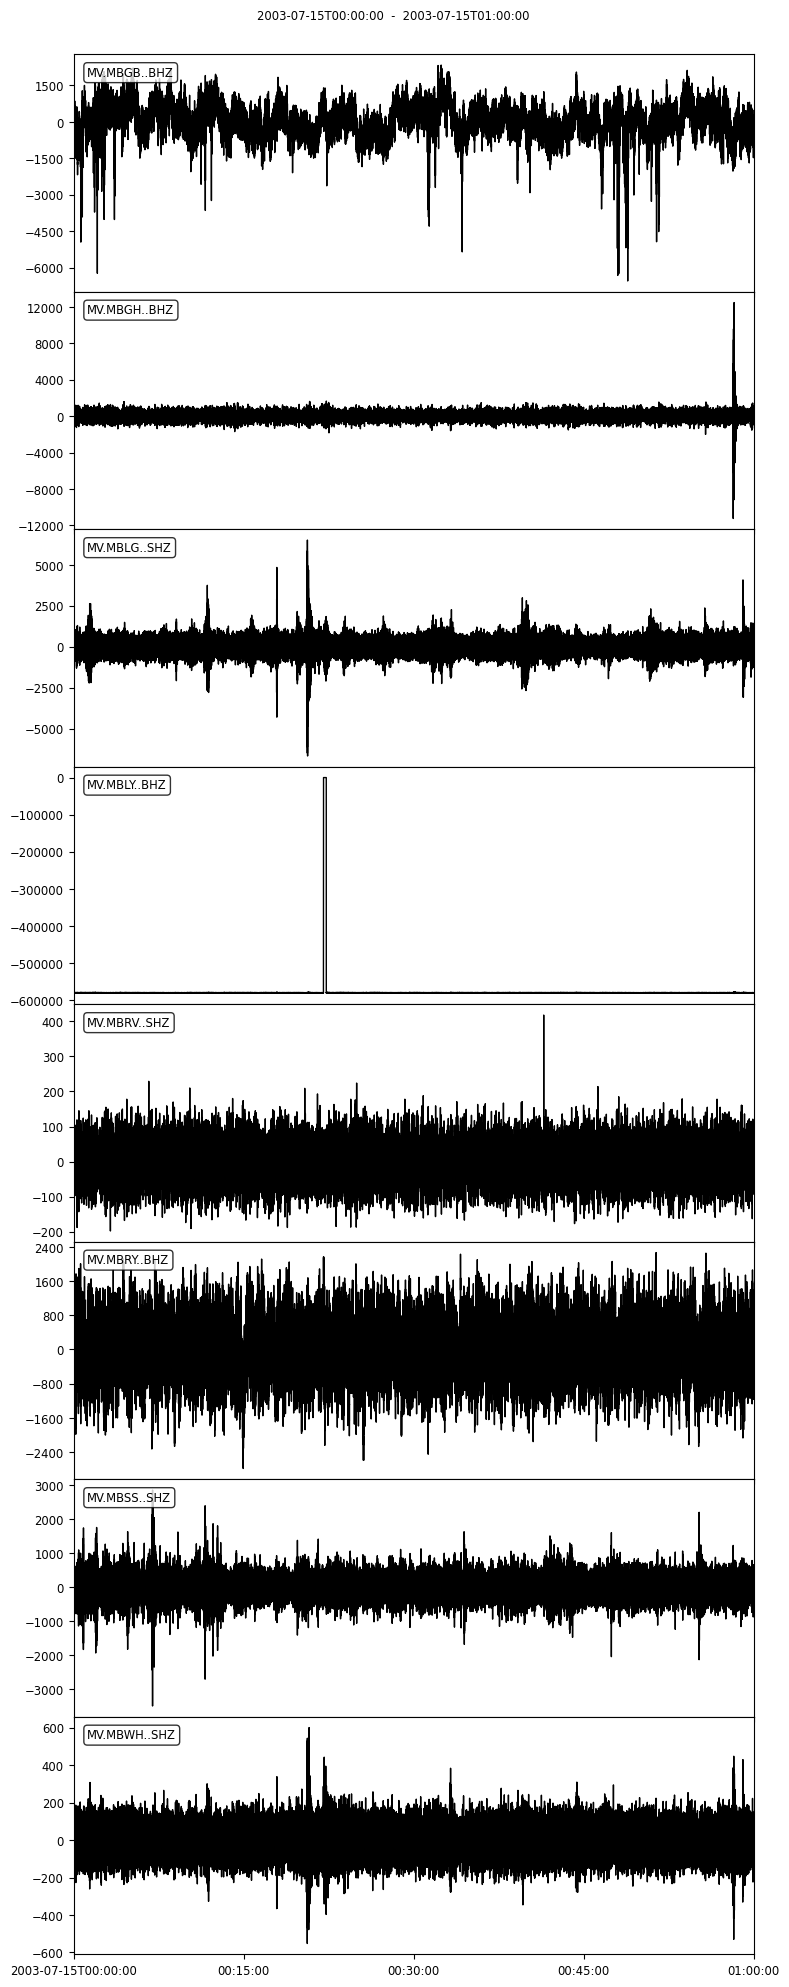

In [14]:
# Get and plot data
seconds = 3600
st = sdsclient.get_waveforms("MV", "*", "*", "?HZ", stime, stime+seconds)
st.plot(equal_scale=False);

Notice that MV.MBLY..BHZ has large spikes and MV.MBGB..BHZ also looks bad. Earlier in the sequence. Let us delete these so they do not mess up detections.

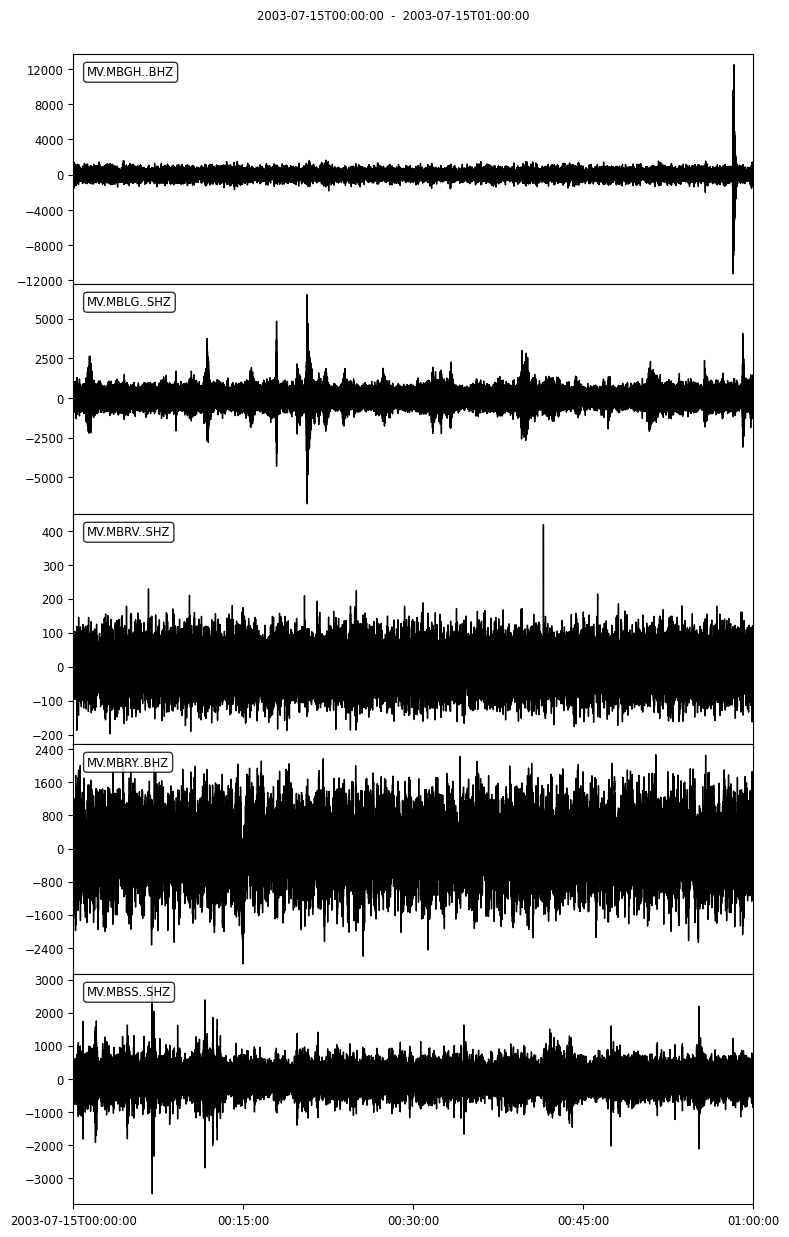

In [15]:
st.remove(st.select(id='MV.MBLY..BHZ')[0])
st.remove(st.select(id='MV.MBGB..BHZ')[0])
st.plot(equal_scale=False);

Run STA/LTA Detector on the final Trace object (MV.MBWH..SHZ) in the Stream. We can use index = -1.

sampling_rate=75


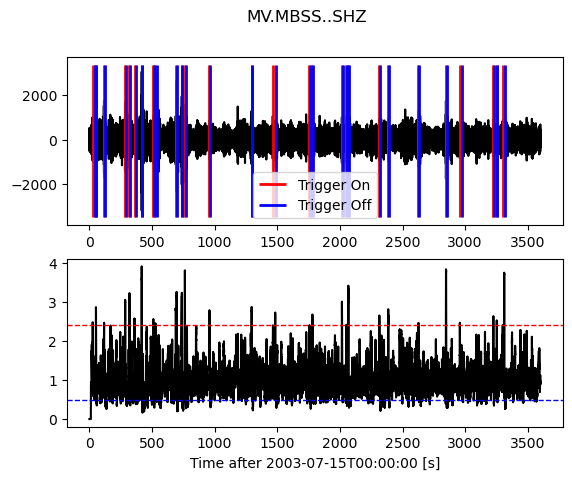

In [16]:
# Detection
import numpy as np
from obspy.signal.trigger import plot_trigger, classic_sta_lta

st2 = st.copy()

tr_index = -1

Fs = int(np.round(st[tr_index].stats.sampling_rate, 0))
print(f"sampling_rate={Fs}")

# Loading parameters here that worked well in Antelope for a mixture of swarms and pathological data
# This 'real time optimization' project was a sort of Monte Carlo search for best parameters that matched 
# closely hand-picked event times while minimizing false events. However, exact methodology of Antelope
# dbdetect unknown.
sta_secs, lta_secs, threshON, threshOFF, freqmin, freqmax, corners = vsmTools.real_time_optimization(band='all')

st2.filter('bandpass', freqmin=freqmin, freqmax=freqmax, corners=corners)
sta_samples = int(sta_secs * Fs)
lta_samples = int(lta_secs * Fs)

#cft = recursive_sta_lta(st2[tr_index].data, sta_samples, lta_samples )
#threshOFF = 1.2
cft = classic_sta_lta(st2[tr_index].data, sta_samples, lta_samples )

plot_trigger(st2[tr_index], cft, threshON, threshOFF)

The top plot shows Trigger ON (red lines) and Trigger OFF (blue lines) times. The bottom line shows the STA:LTA ratio, where "Trigger ON" (red) corresponds to 2.4, and "Trigger OFF" corresponds to 0.5).

## Example 2: Run STA/LTA on all (good) channels
Next we run `coincidence_trigger` on the whole Stream object, choosing the same 'Classic STA/LTA" method as before, and the same input parameters. Since we have 6 'good' channels (Trace objects), we will require at least 3 stations to trigger ON at the same time before a network trigger is declared.

In [17]:
from obspy.signal.trigger import coincidence_trigger
from pprint import pprint

threshStations = 3 # minimum number of channels that must reach trigger ON at the same time before a network trigger is declared.
max_secs = 120.0 # no trigger will remain on for longer than 2 minutes

staltamethod = 'classicstalta'
trig = coincidence_trigger(staltamethod, threshON , threshOFF, st2, threshStations, sta=sta_secs, lta=lta_secs, max_trigger_length=max_secs, details=True)

for i, this_trig in enumerate(trig):
    print('\n',f'Event {i}')
    pprint(this_trig)


 Event 0
{'cft_peak_wmean': 3.1233659373469727,
 'cft_peaks': [2.617872856205013, 4.021819317810901, 2.7304056380250037],
 'cft_std_wmean': 0.8070304498486968,
 'cft_stds': [0.6169588517810961, 1.1829837520495015, 0.6211487457154925],
 'coincidence_sum': 3.0,
 'duration': 26.080000042915344,
 'similarity': {},
 'stations': ['MBRV', 'MBLG', 'MBGH'],
 'time': UTCDateTime(2003, 7, 15, 0, 58, 54, 880000),
 'trace_ids': ['MV.MBRV..SHZ', 'MV.MBLG..SHZ', 'MV.MBGH..BHZ']}


Three network triggers were declared within that one hour time window. 

The trig variable is a list of dictionaries. Each dictionary describes a single network trigger, and contains fields including 'time' which has the UTCDateTime at which the network trigger began, 'coincidence_sum' stores the number of channels that simultaenously triggered (3 for the first two events, 4 for the last), and 'trace_ids' tells us the specific channels that triggered. 

We will assume that each trigger a volcano-seismic event, i.e. a transient (short-lived) anomalous signal. ObsPy includes classes (object-oriented blueprints of new data types useful for Seismology) for storing each `Event` within a `Catalog`. The structure of an ObsPy `Event` object is based on the QuakeML format, and though this isn't great match for volcano-seismic events, we will create an `Event` object for each network trigger. However, rather than use an ObsPy `Catalog` object directly, we have created a new class `VolcanoSeismicCatalog` which inherits `Catalog` and expands on it. This should all be invisible to you - it happens in the `tools` package, imported above. All we have to do is call `tools.triggers2catalog` and it returns a `VolcanoSeismicCatalog` object.

It will also segment out a window of data for each Event beginning pretrig seconds before the trigger ON time and ending posttrig seconds after the trigger OFF time.

In [6]:
import pandas as pd
pretrig = 20 #lta_secs * 2
posttrig = 40 # lta_secs * 2   
#sta_secs, lta_secs, threshON, threshOFF, freqmin, freqmax, corners = tools.real_time_optimization(band='all')
catalogObj = vsmTools.triggers2catalog(trig, staltamethod, threshON, threshOFF, \
                                                  sta_secs, lta_secs, max_secs, stream=st2, pretrig=pretrig, posttrig=posttrig )
    
print(catalogObj)

3 Event(s) in Catalog:
2003-07-15T00:20:33.240000Z | None, None | 2.96 None
2003-07-15T00:33:13.720000Z | None, None | 2.74 None
2003-07-15T00:58:54.880000Z | None, None | 2.89 None


By expanding on the ObsPy `Catalog` class, we have added several new methods, some of which we will use. For example, for each `Event` we create a `Stream` object and can plot those with:


EVENT NUMBER:  1 time:  2003-07-15T00:20:13.240000Z 



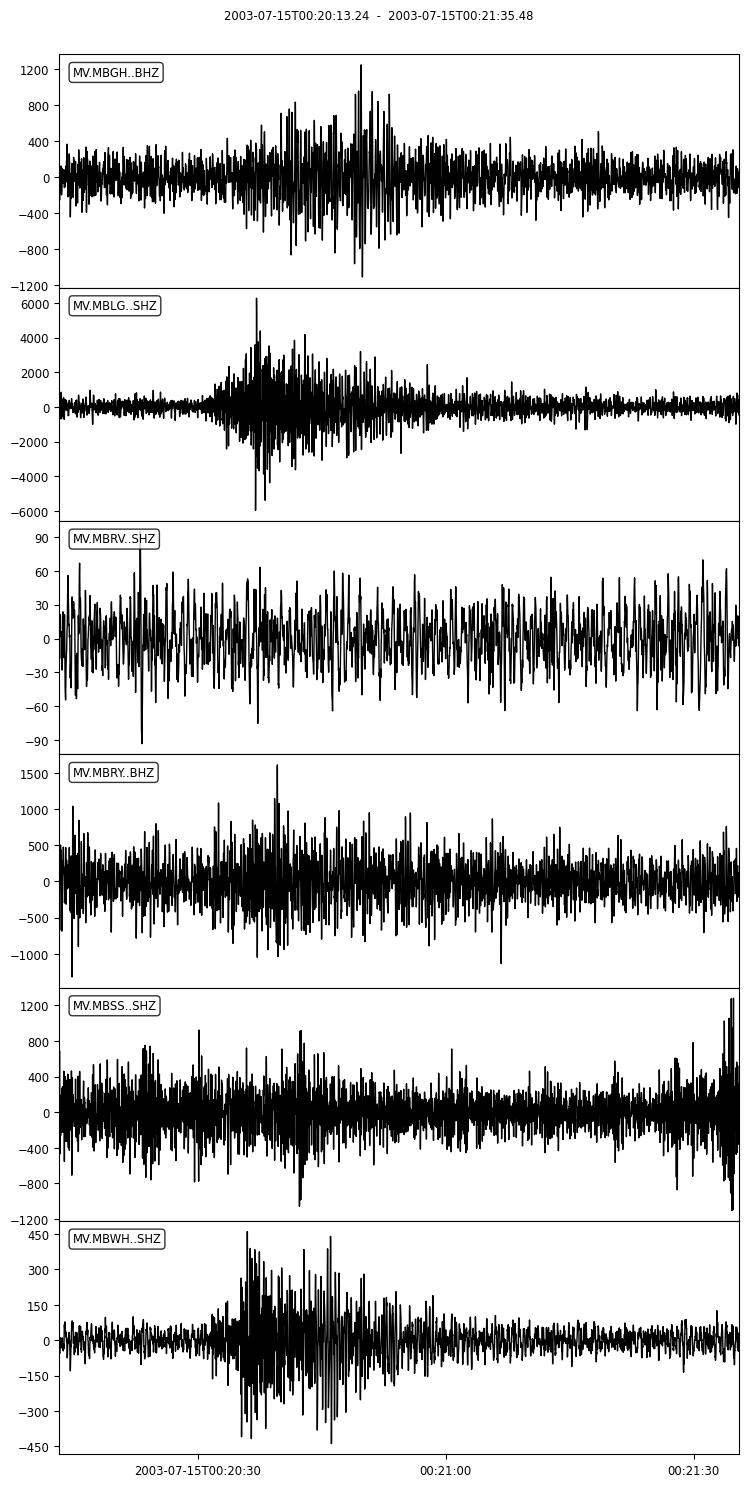


EVENT NUMBER:  2 time:  2003-07-15T00:32:53.720000Z 



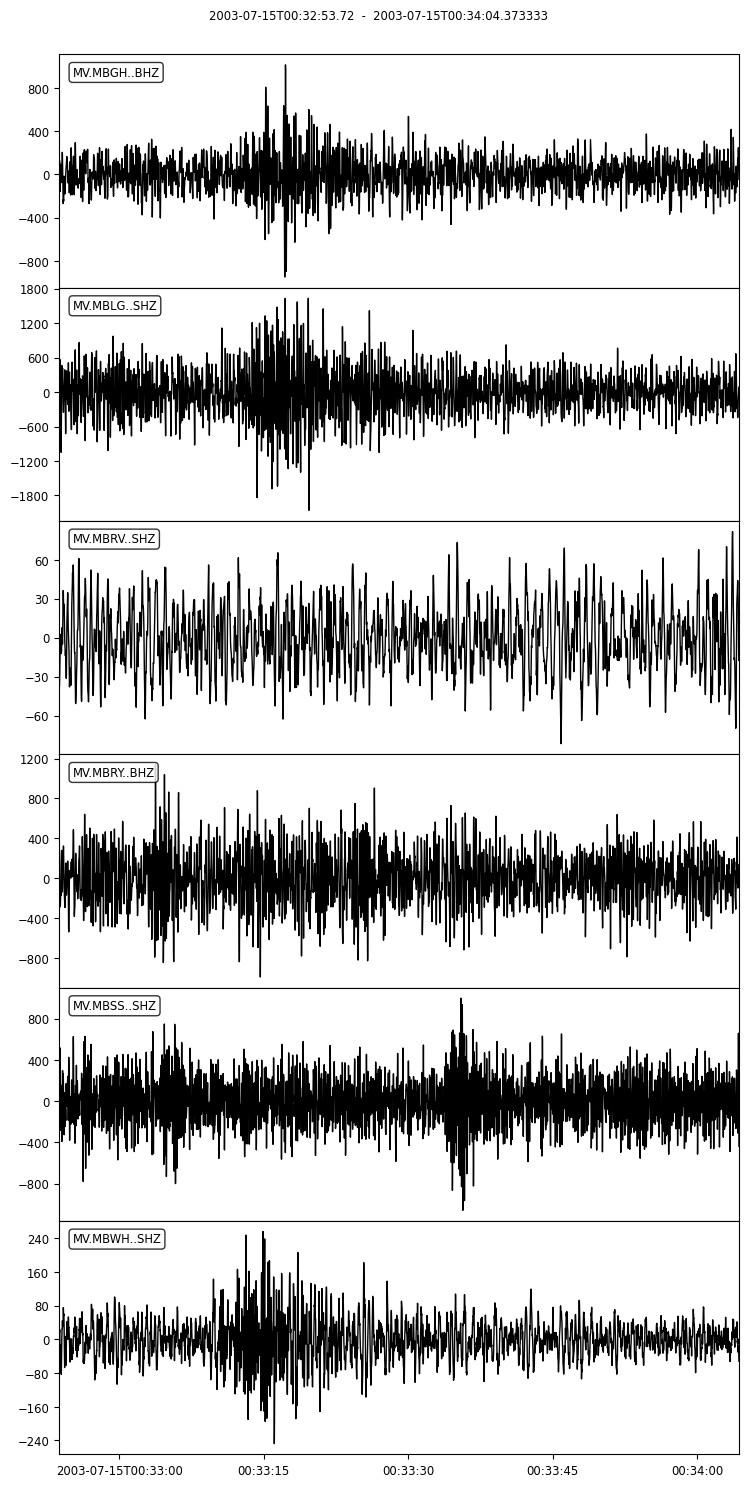


EVENT NUMBER:  3 time:  2003-07-15T00:58:34.880000Z 



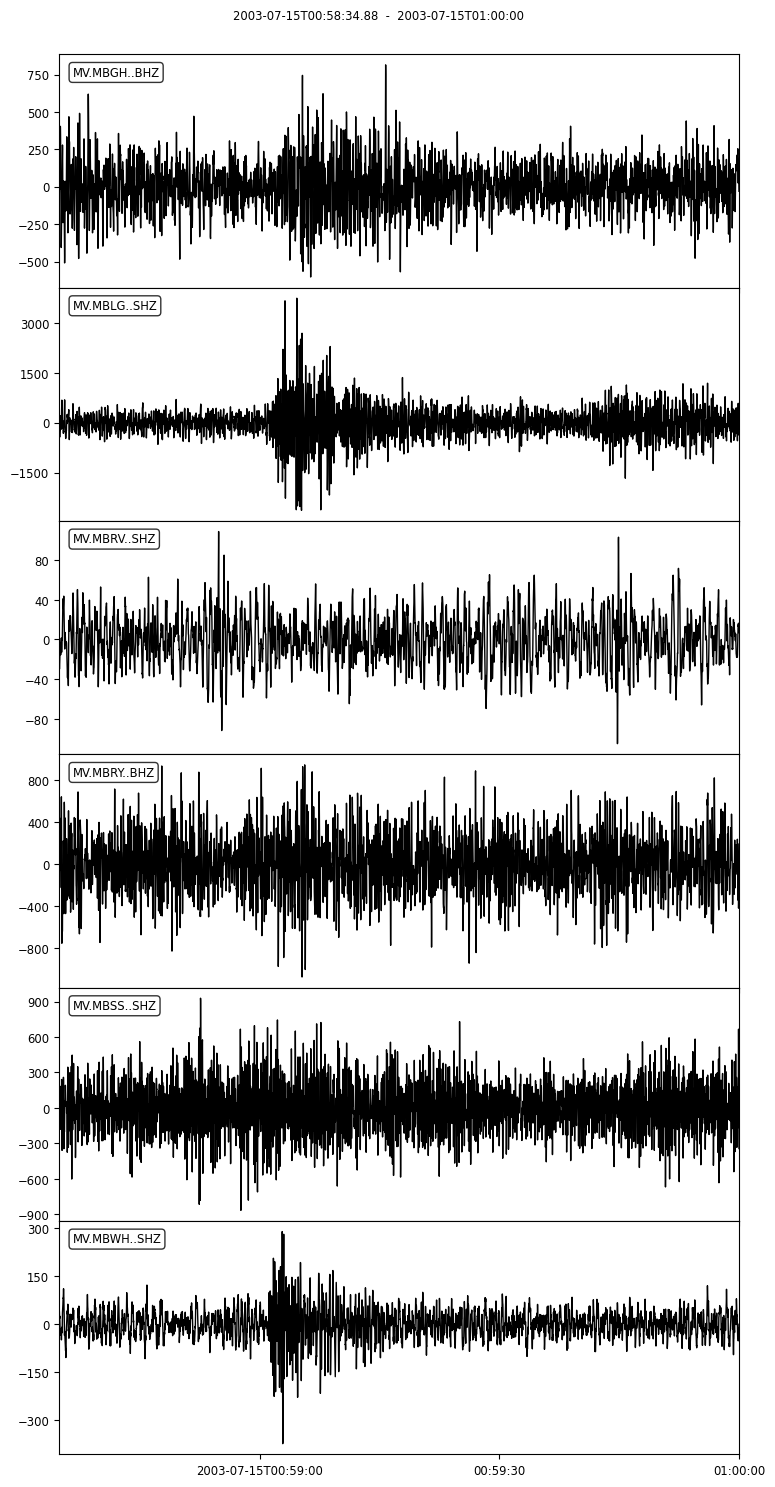

In [7]:
catalogObj.plot_streams()
        

So we have the basic ability to detect events. Unlike the examples in the presentation which are chosen for clarity and having an excellent signal to noise ratio, the events shown in the plots above are not really obvious at all. This is quite typical. Indeed, in this case we are trying to detect events amongst a background of heightened unrest - earthquake swarms that became drumbeat-like and merge into a continuous tremor. It is important to note that STA/LTA algorithms often break down when volcano-seismicity is at its highest!

Anyway, let us now try to run this on several days on data and see how many events we can detect.

## Example 3: Run coincidence trigger on multiple days, and concatenate catalogs for each day into one

In [8]:
import os
import sys
from pprint import pprint 
import obspy
sys.path.append('.')
import vsmTools
SDS_DIR = os.path.join('..', 'data','continuous','SDS')
EVENTS_DIR = os.path.join('..', 'data','events')

# Create a connection to an SDS archive
from obspy.clients.filesystem.sds import Client
sdsclient = Client(str(SDS_DIR))

from obspy.signal.trigger import coincidence_trigger

# set parameters
threshStations = 3 # minimum number of stations that must trigger for a coincidence trigger to occur
max_secs = 120.0
staltamethod = 'classicstalta'
sta_secs, lta_secs, threshON, threshOFF, freqmin, freqmax, corners = vsmTools.real_time_optimization(band='all')

pretrig = 20 #lta_secs * 2
posttrig = 40 # lta_secs * 2   

catalog_all = None

for jday in range(187, 198, 1): # Loop over days in SDS archive
    
    for hour in range(24):

        # set start time
        stime = obspy.UTCDateTime(f"2003{jday}T") + hour * 3600
        print(stime)
    
        # Get and plot data
        st = sdsclient.get_waveforms("MV", "*", "*", "?HZ", stime, stime+3600)
        if len(st)==0:
            continue
    
        # remove bad channels, including those with insufficient samples
        for tr in st:
            if tr.stats.station == 'MBLY' or tr.stats.station == 'MBGB' or tr.stats.npts < max_secs * tr.stats.sampling_rate:
                st.remove(tr)

        if len(st)==0:
            continue
    
        # bandpass filter
        st.filter('bandpass', freqmin=freqmin, freqmax=freqmax, corners=corners)
    
        # run coincidence trigger for this day
        trig = coincidence_trigger(staltamethod, threshON , threshOFF, st, threshStations, sta=sta_secs, lta=lta_secs, max_trigger_length=max_secs, details=True)
        if len(trig)==0:
            continue

        '''
        for i, this_trig in enumerate(trig):
            print(i, this_trig['time'])
        '''
            
        # create catalog object
        catalogObj = vsmTools.triggers2catalog(trig, staltamethod, threshON, threshOFF, \
                                                      sta_secs, lta_secs, max_secs, stream=st, pretrig=pretrig, posttrig=posttrig )
    
        # save the event streams to miniseed, and then erase them to free up memory
        catalogObj.write_events(outdir=EVENTS_DIR)
        catalogObj.streams = []
    
        # concatenate catalogs
        if catalog_all:
            catalog_all.concat(catalogObj)
        else:
            catalog_all = catalogObj

2003-07-06T00:00:00.000000Z
2003-07-06T01:00:00.000000Z
2003-07-06T02:00:00.000000Z
2003-07-06T03:00:00.000000Z
2003-07-06T04:00:00.000000Z
2003-07-06T05:00:00.000000Z
2003-07-06T06:00:00.000000Z
2003-07-06T07:00:00.000000Z
2003-07-06T08:00:00.000000Z
2003-07-06T09:00:00.000000Z
2003-07-06T10:00:00.000000Z
2003-07-06T11:00:00.000000Z
2003-07-06T12:00:00.000000Z
2003-07-06T13:00:00.000000Z
2003-07-06T14:00:00.000000Z
2003-07-06T15:00:00.000000Z
2003-07-06T16:00:00.000000Z
2003-07-06T17:00:00.000000Z
2003-07-06T18:00:00.000000Z
2003-07-06T19:00:00.000000Z
2003-07-06T20:00:00.000000Z
2003-07-06T21:00:00.000000Z
2003-07-06T22:00:00.000000Z
2003-07-06T23:00:00.000000Z
0 2003-07-06T23:40:14.200000Z
Writing ../data/events/WAV/MV/2003/07/20030706T234014.mseed
2003-07-07T00:00:00.000000Z
0 2003-07-07T00:00:14.200000Z
1 2003-07-07T00:02:56.920000Z
2 2003-07-07T00:34:46.093333Z
3 2003-07-07T00:51:51.813333Z
Writing ../data/events/WAV/MV/2003/07/20030707T000014.mseed
Writing ../data/events/WAV/MV/

/home/thompsong/miniconda3/envs/skience24/lib/python3.11/site-packages/obspy/io/mseed/core.py:770: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


0 2003-07-07T02:02:38.946667Z
1 2003-07-07T02:42:21.053333Z
Writing ../data/events/WAV/MV/2003/07/20030707T020238.mseed
Writing ../data/events/WAV/MV/2003/07/20030707T024221.mseed
2003-07-07T03:00:00.000000Z
0 2003-07-07T03:00:11.840000Z
1 2003-07-07T03:03:17.226666Z
2 2003-07-07T03:16:07.640000Z
3 2003-07-07T03:41:23.280000Z
Writing ../data/events/WAV/MV/2003/07/20030707T030011.mseed
Writing ../data/events/WAV/MV/2003/07/20030707T030317.mseed
Writing ../data/events/WAV/MV/2003/07/20030707T031607.mseed
Writing ../data/events/WAV/MV/2003/07/20030707T034123.mseed
2003-07-07T04:00:00.000000Z
0 2003-07-07T04:53:59.773334Z
Writing ../data/events/WAV/MV/2003/07/20030707T045359.mseed
2003-07-07T05:00:00.000000Z
0 2003-07-07T05:00:14.200000Z
1 2003-07-07T05:08:06.400000Z
2 2003-07-07T05:12:17.586666Z
3 2003-07-07T05:13:01.933333Z
4 2003-07-07T05:48:40.880000Z
5 2003-07-07T05:58:16.626666Z
Writing ../data/events/WAV/MV/2003/07/20030707T050014.mseed
Writing ../data/events/WAV/MV/2003/07/20030707

In [9]:
print(catalog_all)
catalog_all.save(CATALOG_DIR,'catalog_MV_200307')

3225 Event(s) in Catalog:
2003-07-06T23:40:14.200000Z | None, None | 2.92 None
2003-07-07T00:00:14.200000Z | None, None | 3.23 None
...
2003-07-16T05:09:45.626667Z | None, None | 3.51 None
2003-07-16T05:18:17.533334Z | None, None | 2.93 None
To see all events call 'print(CatalogObject.__str__(print_all=True))'


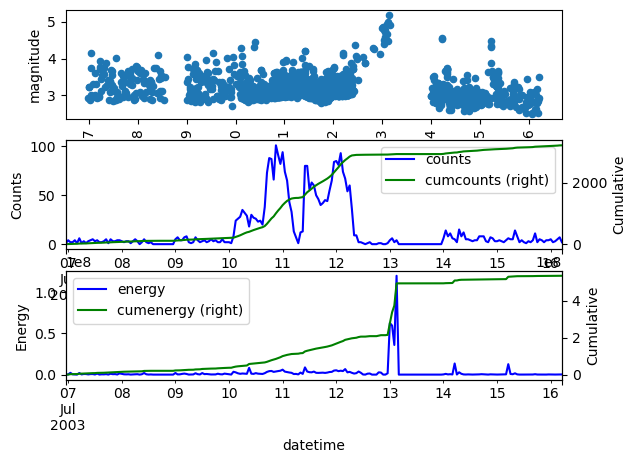

In [10]:
import pandas as pd
catalog_all.plot_eventrate(binsize=pd.Timedelta(hours=1))